In [6]:
from google.colab import drive

# Mount Google Drive to /content/drive
drive.mount('/content/drive')

dir_data = '/content/drive/MyDrive/datasets/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install keras==3.0.0

## Importando os pacotes

In [7]:
import os, glob
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
# Ensure plots are displayed in the Jupyter Notebook
%matplotlib inline


os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops
import tensorflow as tf

## Funções importantes para utilização dos dados e plots

In [8]:
def plot_signals(signals, title=None):
    t = np.arange(signals.shape[0])  # Time steps

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    labels = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']

    # Plot the first three signals on one graph
    for i in range(3):
        ax1.plot(t, signals[:, i], label=labels[i])

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Accelerometer')
    ax1.legend()

    # Plot the last three signals on the other graph
    for i in range(3, 6):
        ax2.plot(t, signals[:, i], label=labels[i])

    ax2.set_xlabel('Time')
    ax2.set_ylabel('Amplitude')
    ax2.set_title('Gyroscopy')
    ax2.legend()

    if title:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()


In [9]:
def show_joint_3D(skeleton):
    total_joint = 20

    J = np.array([[1, 2, 3, 2, 5, 6, 7, 2, 9, 10, 11, 4, 13, 14, 15, 4, 17, 18, 19],
                  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]])

    ss = []

    num_frame = skeleton.shape[2]

    for i in range(num_frame):
        ss.append(skeleton[:, :, i])

    ss = np.vstack(ss)

    maxx = np.max(ss[:, 0])
    minx = np.min(ss[:, 0])
    maxy = np.max(ss[:, 1])
    miny = np.min(ss[:, 1])
    maxz = np.max(ss[:, 2])
    minz = np.min(ss[:, 2])

    for i in range(num_frame):
        fig = plt.figure(figsize=(6, 10))
        ax = fig.add_subplot(111, projection='3d')

        joint = skeleton[:, :, i]
        ax.scatter(joint[:, 0], joint[:, 2], joint[:, 1], c='r', marker='.', s=15)
        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.set_zlabel('Y')

        for j in range(total_joint):
            tmp = joint[j, :]
            ax.scatter(tmp[0], tmp[2], tmp[1], c='r', marker='.', s=15)

        ax.set_box_aspect([1, 1, 1])

        for j in range(J.shape[1]):
            point1 = joint[J[0, j] - 1, :]
            point2 = joint[J[1, j] - 1, :]
            ax.plot([point1[0], point2[0]], [point1[2], point2[2]], [point1[1], point2[1]], linewidth=2)

        ax.set_xlim(minx, maxx)
        ax.set_ylim(minz, maxz)
        ax.set_zlim(miny, maxy)
        ax.grid()

        plt.pause(1/20)
        plt.close()


## Funções importante para interpolação de dados

In [10]:
import numpy as np
from scipy.interpolate import interp1d

# Interpolation function
def interpolate_data(data, new_t, method='linear'):
    t, points, axis = data.shape
    interpolated_data = np.zeros((new_t, points, axis))

    for i in range(axis):
        for j in range(points):
            x = np.linspace(0, t - 1, t)  # Original time points
            y = data[:, j, i]

            # Create an interpolation function with the specified method
            interp_func = interp1d(x, y, kind=method, fill_value='extrapolate')

            # Interpolate for the new time points
            x_new = np.linspace(0, t - 1, new_t)  # New time points
            interpolated_data[:, j, i] = interp_func(x_new)

    return interpolated_data


def interpolate_sensors(new_t, data, kind='linear'):
    t = data.shape[0]
    old_indices = np.arange(t)
    new_indices = np.linspace(0, t - 1, new_t)


    interpolated_data = np.zeros((new_t, data.shape[1]))
    for col in range(data.shape[1]):
        # Interpolate each column separately
        interpolator = interp1d(old_indices, data[:, col], kind=kind)
        interpolated_data[:, col] = interpolator(new_indices)

    return interpolated_data

## Preprocessando os dados de esqueleto

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import cv2
import os

# Create a directory to store frame images
os.makedirs("frames", exist_ok=True)

def save_joint_frame(skeleton, frame_index):
    total_joint = 20

    J = np.array([[1, 2, 3, 2, 5, 6, 7, 2, 9, 10, 11, 4, 13, 14, 15, 4, 17, 18, 19],
                  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]])

    fig = plt.figure(figsize=(6, 10))
    ax = fig.add_subplot(111, projection='3d')

    joint = skeleton[:, :, frame_index]
    ax.scatter(joint[:, 0], joint[:, 2], joint[:, 1], c='r', marker='.', s=15)
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

    for j in range(total_joint):
        tmp = joint[j, :]
        ax.scatter(tmp[0], tmp[2], tmp[1], c='r', marker='.', s=15)

    ax.set_box_aspect([1, 1, 1])

    for j in range(J.shape[1]):
        point1 = joint[J[0, j] - 1, :]
        point2 = joint[J[1, j] - 1, :]
        ax.plot([point1[0], point2[0]], [point1[2], point2[2]], [point1[1], point2[1]], linewidth=2)

    ax.set_xlim(minx, maxx)
    ax.set_ylim(minz, maxz)
    ax.set_zlim(miny, maxy)
    ax.grid()

    # Save the frame as an image
    plt.savefig(f"frames/frame_{frame_index:04d}.png")
    plt.close()


"""skeleton_data = skl_data

ss = []

num_frame = skeleton_data.shape[2]

for i in range(num_frame):
    ss.append(skeleton_data[:, :, i])

ss = np.vstack(ss)

maxx = np.max(ss[:, 0])
minx = np.min(ss[:, 0])
maxy = np.max(ss[:, 1])
miny = np.min(ss[:, 1])
maxz = np.max(ss[:, 2])
minz = np.min(ss[:, 2])

# Loop through frames and save each frame as an image
total_frames = skeleton_data.shape[2]
for frame_index in range(total_frames):
    save_joint_frame(skeleton_data, frame_index)


#Saving a video from skeleton videos
image_folder = 'frames'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
print(sorted(images))
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()"""

'skeleton_data = skl_data\n\nss = []\n\nnum_frame = skeleton_data.shape[2]\n\nfor i in range(num_frame):\n    ss.append(skeleton_data[:, :, i])\n\nss = np.vstack(ss)\n\nmaxx = np.max(ss[:, 0])\nminx = np.min(ss[:, 0])\nmaxy = np.max(ss[:, 1])\nminy = np.min(ss[:, 1])\nmaxz = np.max(ss[:, 2])\nminz = np.min(ss[:, 2])\n\n# Loop through frames and save each frame as an image\ntotal_frames = skeleton_data.shape[2]\nfor frame_index in range(total_frames):\n    save_joint_frame(skeleton_data, frame_index)\n\n\n#Saving a video from skeleton videos\nimage_folder = \'frames\'\nvideo_name = \'video.avi\'\n\nimages = [img for img in os.listdir(image_folder) if img.endswith(".png")]\nprint(sorted(images))\nframe = cv2.imread(os.path.join(image_folder, images[0]))\nheight, width, layers = frame.shape\n\nvideo = cv2.VideoWriter(video_name, 0, 1, (width,height))\n\nfor image in images:\n    video.write(cv2.imread(os.path.join(image_folder, image)))\n\ncv2.destroyAllWindows()\nvideo.release()'

## Preprocessando dataset e preparando para executar

In [12]:
debug = False
plot = False
interp = True
# Define the new number of values, interpolation method, and desired output shape
new_t = 150
new_ts = 250
interpolation_method = 'linear'  # Change to 'cubic', 'quadratic', etc. as needed

def normalize_sensors(sensor):
  return sensor

def normalize_skeleton(sklt):
  return sklt

def prepare_dataset(dir_data):
  sensors = os.path.join(dir_data, 'inertial')
  sklts = os.path.join(dir_data, 'skeleton')

  sensors = os.listdir(sensors)
  sklts = os.listdir(sklts)

  sensors = [s.replace('inertial.mat', '') for s in sensors]
  sklts = [s.replace('skeleton.mat', '') for s in sklts]

  list_dir = list(dict.fromkeys(sensors + sklts))

  n_people = []
  data_ssr, data_skl = {}, {}

  for file_ in list_dir:
    try:
      inert = scipy.io.loadmat(os.path.join(dir_data, 'inertial',file_+'inertial.mat'))
    except:
      print(file_)
      continue
    signals = inert['d_iner']
    if interp:
      # Interpolate data to new_t using cubic interpolation
      signals = interpolate_sensors(new_t, signals, kind='cubic')
    signals = normalize_sensors(signals)
    ind = file_.split('_')[1]
    #signals = np.transpose(signals,(1,0))
    #prints and plots
    if debug:
      print(signals.shape)
      if plot:
        # Plot the signals in the Jupyter Notebook
        plot_signals(signals, title='Signals')

    try:
      sklet = scipy.io.loadmat(os.path.join(dir_data, 'skeleton',file_+'skeleton.mat'))
    except:
      print(file_)
      continue
    sklet = sklet['d_skel']
    #(joints, axis, time)
    skel_ = np.transpose(sklet,(2,0,1))
    #(time, joints, axis)

    if interp:
      shp = skel_.shape
      # Sample data with shape (t, points, axis)
      t = shp[0]  # Number of time steps
      points = shp[1] # Number of points
      axis = shp[2]  # Number of axes

      # Interpolate the data
      skel_ = interpolate_data(skel_, new_ts, interpolation_method)
      if debug:
        # Print the original and interpolated data for illustration
        print("Original Data Shape:", shp)
        print("Interpolated Data Shape:", skel_.shape)
    shp = skel_.shape
    # Sample data with shape (t, points, axis)
    t = shp[0]  # Number of time steps
    #keep time ou keep space
    #new_skel = skel_.reshape(t, -1)
    new_skel = np.transpose(skel_,(0,1,2))
    new_skel = normalize_skeleton(new_skel)

    if ind in data_ssr:
      data_ssr[ind].append(signals)
      data_skl[ind].append(new_skel)
    else:
      data_ssr[ind] = [signals]
      data_skl[ind] = [new_skel]
    #prints and plots
    if debug:
      print(sklet.shape)
      if plot:
        show_joint_3D(new_skel)

  #sensors_data, skeleton_data = np.array(sensors_data), np.array(skeleton_data)

  if debug:
    print('Shape data {}'.format(data_ssr.shape))

  return data_skl, data_ssr


data_skl, data_ssr = prepare_dataset(dir_data)

a5_s2_t3_skeleton (1).mat
a18_s2_t1_skeleton (1).mat
a4_s7_t2_skeleton (1).mat
a5_s8_t1_skeleton (1).mat
a1_s3_t2_skeleton (1).mat
a9_s3_t1_skeleton (1).mat
a19_s3_t2_skeleton (1).mat
a22_s3_t3_skeleton (1).mat
a1_s4_t3_skeleton (1).mat
a5_s4_t3_skeleton (1).mat


## Criando o modelo proposto

In [13]:
input_shape = (224, 224, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    32,
    64,
]  # Size of the dense layers of the final classifier


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def processing_input(x):
    # Convolutional layers to process the input
    x = layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(72 * 72 * 3, activation='sigmoid')(x)
    output_layer = layers.Reshape((72, 72, 3))(x)
    return output_layer

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

def create_vit_classifier():
    inputs = keras.Input(shape=(250, 20, 3))
    # Augment data.
    #augmented = data_augmentation(inputs)
    out_conv = processing_input(inputs)
    # Create patches.
    patches = Patches(patch_size)(out_conv)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # out axi X
    X = layers.Dense(150, activation='linear', name='X')(features)
    # out axi Y
    Y = layers.Dense(150, activation='linear', name='Y')(features)
    # out axi Z
    Z = layers.Dense(150, activation='linear', name='Z')(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=[X,Y,Z])
    return model



def custom_dynamic_mse():
    def loss(y_true, y_pred):
        # Calculate the size of values in the second dimension for each sample
        sizes = ops.sum(ops.sign(y_true), axis=1, keepdims=True)

        # Create a mask to zero out irrelevant values in y_pred for each sample
        mask = ops.sequence_mask(sizes[:, 0, 0], maxlen=254, dtype=ops.floatx())

        # Calculate MSE only for the relevant values
        squared_diff = ops.square(y_pred - y_true)
        mse = ops.sum(squared_diff * mask) / ops.sum(mask + 1e-8)  # Avoid division by zero

        return mse

    return loss




## Treinando e avaliando o modelo

In [14]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

def run_experiment(model, X_train, y_train, batch_, epoch_):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(optimizer=optimizer,
              loss={'X': 'mse', 'Y': 'mse', 'Z': 'mse'},
              metrics={'X': 'mse', 'Y': 'mse', 'Z': 'mse'})

    checkpoint_filepath = "/content/drive/MyDrive/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_mae",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=np.array(X_train),
        y=[y_train[:,:,0],y_train[:,:,1], y_train[:,:,2]],
        batch_size=batch_,
        epochs=epoch_,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
    #model.save(checkpoint_filepath)

    return history, model

Key: s1, Shape: 107
Epoch 1/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 154s 7s/step - X_mse: 1.5117 - Y_mse: 0.8470 - Z_mse: 0.7905 - loss: 3.1463 - val_X_mse: 0.8790 - val_Y_mse: 0.2644 - val_Z_mse: 0.2957 - val_loss: 1.2813
Epoch 2/35


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:205: UserWarning: Can save best model only with val_mae available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - X_mse: 1.0201 - Y_mse: 0.3878 - Z_mse: 0.3158 - loss: 1.7237 - val_X_mse: 0.8640 - val_Y_mse: 0.2594 - val_Z_mse: 0.2943 - val_loss: 1.2596
Epoch 3/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - X_mse: 0.9869 - Y_mse: 0.3669 - Z_mse: 0.3115 - loss: 1.6657 - val_X_mse: 0.8481 - val_Y_mse: 0.2543 - val_Z_mse: 0.2930 - val_loss: 1.2368
Epoch 4/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - X_mse: 0.9701 - Y_mse: 0.3623 - Z_mse: 0.3041 - loss: 1.6369 - val_X_mse: 0.8310 - val_Y_mse: 0.2491 - val_Z_mse: 0.2917 - val_loss: 1.2128
Epoch 5/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - X_mse: 0.9610 - Y_mse: 0.3560 - Z_mse: 0.2943 - loss: 1.6117 - val_X_mse: 0.8118 - val_Y_mse: 0.2436 - val_Z_mse: 0.2906 - val_loss: 1.1866
Epoch 6/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - X_mse: 0.9591 - Y_mse: 0.3528 - Z_mse: 0.3071 - loss: 1.6192 - val_X_mse: 0.7899 - val_Y_mse: 0.2378 - val_Z_mse: 0.2894 - val_loss: 1.1574
Epoch 7/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms

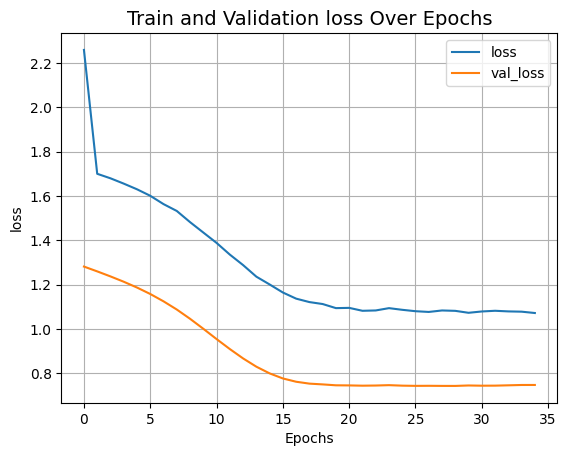

In [17]:
from sklearn.datasets import make_regression
# create dataset
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=3, random_state=2)
# summarize shape
result = []
for key in data_ssr.keys():
    X_train, y_train, X_test, y_test = [], [], [], []
    # Get the list associated with the key
    current_list = data_ssr[key]
    # Get the shape (length) of the list
    list_shape = len(current_list)
    # Print key and shape
    print(f"Key: {key}, Shape: {list_shape}")
    for v in data_ssr.keys():
      if v == key:
        X_test = np.array(data_skl[v])
        y_test = np.array(data_ssr[v])
      else:
        if len(X_train) == 0:
          X_train = data_skl[v]
          y_train = data_ssr[v]
        else:
          X_train = np.concatenate([X_train,data_skl[v]])
          y_train = np.concatenate([y_train,data_ssr[v]])

    vit_classifier = create_vit_classifier()
    history, model = run_experiment(vit_classifier, X_train, y_train, batch_=64, epoch_=35)

    #model = keras.models.load_model(checkpoint_filepath)
    y_pred = model.predict(X_test)
    output = model.evaluate(X_test, [y_test[:,:,0],y_test[:,:,1],y_test[:,:,2]])
    print(f"Error: {output}")
    result.append(output)
    del model
    break

plot_history("loss")

In [ ]:
while True:pass

In [ ]:
import numpy as np

# Example array with shape (t, f, a)
t, f, a = 3, 4, 2
original_array = np.random.rand(t, f, a)

# Reshape to (t, f*a)
reshaped_array = original_array.reshape(t, f * a)

# Verify the shapes
print("Original array shape:", original_array.shape)
print("Reshaped array shape:", reshaped_array.shape)

# Verify if reshaping back to the original shape retains the values
restored_array = reshaped_array.reshape(t, f, a)
print("Restored array shape:", restored_array.shape)

# Check if the original and restored arrays are equal
print("Arrays are equal:", np.array_equal(original_array, restored_array))


Original array shape: (3, 4, 2)
Reshaped array shape: (3, 8)
Restored array shape: (3, 4, 2)
Arrays are equal: True
